Notebook presenting basic implementation of Gillespie's direct algorithm for simulating an SIR process on a network.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt


#from numpy.random import seed, rand
from numpy.random import Generator, PCG64

In [2]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x000001D0E1DE0300>


# SIR on network

In [3]:
##################################################################################################
def calculate_node_propensities(G, beta, mu):
    
    N                 = len(G)
    a_sum             = 0
    
    nx.set_node_attributes(G, 'a', 0)
    
    for i in range(N):
        #--- If node is susceptible calculate total propensity for infection: ---
        if G.nodes[i]['state'] == 0:
            # Get i's neighbors:
            neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)] 

            # Total propensity from number of neighbors that are infectious:
            a_i = beta * np.sum([state==1 for state in neighbor_states])
            
            # Set node propensity:
            G.nodes[i]['a'] = a_i
            
            # Add to total propensity:
            a_sum += a_i
            
        #--- If node is infectious set propensity to mu: ---
        elif G.nodes[i]['state'] == 1:
            # Set node propensity:
            G.nodes[i]['a'] = mu                   
            
            # Add to total propensity:
            a_sum += mu
    
    return(a_sum)
##################################################################################################
##################################################################################################
def direct_event_draw_graph(a_sum, G):
    u1, u2 = rg.random(2)

    # Draw waiting time and increment time:
    tau = - np.log(1. - u1) / a_sum # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)

    #--- Select reaction: ---
    target_sum = u2 * a_sum
    sum_i = 0

    for i,attributes in G.nodes(data=True): 
        sum_i += attributes['a']

        if sum_i >= target_sum:
            break
    
    return(tau, i)
##################################################################################################
##################################################################################################
def update_states_graph(G, X, a_sum, i):
    state_before = G.nodes[i]['state']

    #--- If state_before was S, update to I: ---
    if state_before==0:             
        # Update state counts: 
        X[0] -= 1
        X[1] += 1

        # Update state of node in graph (S -> I): 
        G.nodes[i]['state'] = 1

        # Update i's propensity:
        a_sum += -G.nodes[i]['a'] + mu
        G.nodes[i]['a'] = mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                G.nodes[j]['a'] += beta
                a_sum += beta

    #--- Else, if state_before was I, update to R: ---
    else: # (Note that this is a simple else statement since state_before is either S or I)
        # Update state counts: 
        X[1] -= 1
        X[2] += 1

        # Update state of node in graph: 
        G.nodes[i]['state'] = 2

        # Update i's propensity:
        G.nodes[i]['a'] = 0.
        a_sum -= mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                G.nodes[j]['a'] -= beta
                a_sum -= beta

    return(X, a_sum)
##################################################################################################
##################################################################################################
def direct_method_SIR_graph_linear(G, beta, mu, T):
    
    #--- Initialization: ---
    node_states = nx.get_node_attributes(G, 'state')
    
    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I 

    # Calculate and store node propensities:
    a_sum = calculate_node_propensities(G, beta, mu)    

    # Set initial time t = 0:
    t = 0

    # Vector to save temporal evolution of state numbers over time: 
    X_t = [] 
    X_t.append([t, S, I, R])
    
    #--- Keep drawing events until t >= T: ---
    while t < T:
        # Check for a_sum == 0 (no more reactions can happen):
        if np.isclose(a_sum, 0.):
            X_t.append([T, S, I, R])
            break
        
        #===== Direct event sampling step: =====
        tau, i = direct_event_draw_graph(a_sum, G) 
        t += tau
                
        #===== Update states: =====
        [S, I, R], a_sum = update_states_graph(G, [S,I,R], a_sum, i)
        
        #--- Save current state numbers to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose()) #, states_t)
##################################################################################################



## $k$-regular graph 

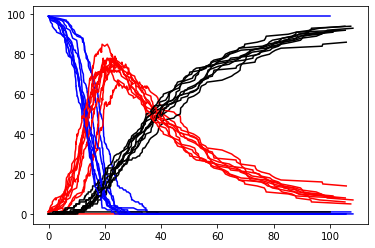

In [13]:
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 100  # Simulation duration

Q = 10

G = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

#ax.axis([0,T,0,N])


In [14]:
nx.set_node_attributes(G, 'state', 0)
for i,state in enumerate(states):
    G.nodes[i]['state'] = state       
    
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

In [15]:
%%timeit

G1 = G.copy()
direct_method_SIR_graph_linear(G1, beta, mu, T)

24.7 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## ER graph 

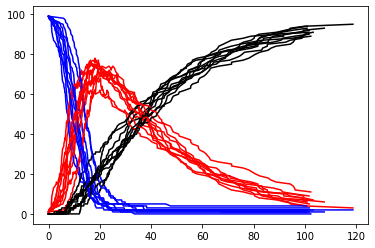

In [11]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 10

G = nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)
    
#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

##  BA graph

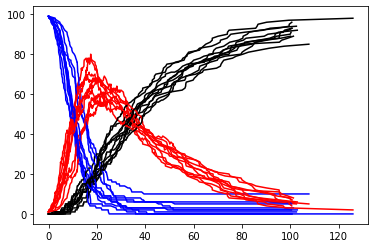

In [12]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 4     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

Q = 10

G = nx.barabasi_albert_graph(n=N, m=int(k/2))

X_array = []

for q in range(Q):
    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]